# Import necessary libraries #

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam

c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Load our data #
Here, we are loading data from MNIST dataset.

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# to get the shape of the data
print("x_train shape:", x_train.shape)
print("x_test shape", x_test.shape)

x_train shape: (60000, 28, 28)
x_test shape (10000, 28, 28)


# Understanding and visualizing our data #
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten
digits that is commonly used for training various image processing systems. The database is also widely used for
training and testing in the field of machine learning. The MNIST database contains 60,000 training images and 10,000
testing images, with their correspoinding labels. These images are grayscale image of 28 by 28 pixels.

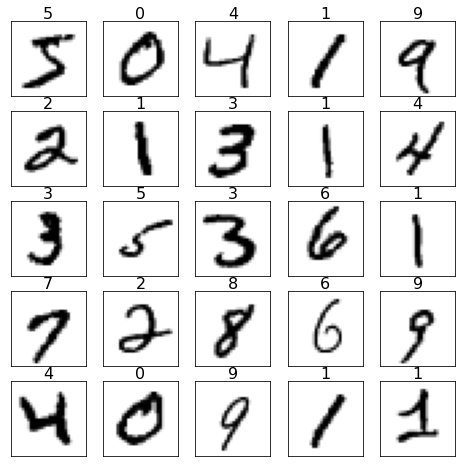

In [3]:
plt.figure(figsize=(8, 8))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.title(str(y_train[i]), fontsize=16, color='black', pad=2)
  plt.imshow(x_train[i], cmap=plt.cm.binary)
  plt.xticks([])
  plt.yticks([])

# Spliting test data for validation and testing #
Here, we will divide test data into validation data and test data (90% of our test data for validation and remaining 10% for testing) so that we can use validation data to avoid
overfitting and can use testing data to test the performance of our CNN model.

In [4]:
val_images = x_test[:9000]
test_images = x_test[9000:]

# Normalizing and reshaping #
Here, pixel value for our training, validating and testing images are in range between 0 to 255. In order to reduce
data inconsistency we have to normalize the data. So, we are reshaping our images so that all images are of same shape
and all can be feed into the network.
Here, train images have maximum value of 255, and minimum value of 0. So, for normalizing we simply can divide data
by 255.

In [5]:
val_images = val_images.astype('float32') / 255.0
val_images = np.reshape(val_images, (val_images.shape[0], 28, 28, 1))

test_images = test_images.astype('float32') / 255.0
test_images = np.reshape(test_images, (test_images.shape[0], 28, 28, 1))

train_images = x_train.astype("float32") / 255.0
train_images = np.reshape(train_images, (train_images.shape[0], 28, 28, 1))

# Adding noise #
Here we are adding random numbers the our images so that our image look noisy, and we can feed them as input to our
network along with non noisy image as target so that our network learns to denoise image.

In [6]:
factor = 0.39
train_noisy_images = train_images + factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
val_noisy_images = val_images + factor * np.random.normal(loc=0.0, scale=1.0, size=val_images.shape)
test_noisy_images = test_images + factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)

# here maximum pixel value for our images may exceed 1 so we have to clip the images
train_noisy_images = np.clip(train_noisy_images, 0., 1.)
val_noisy_images = np.clip(val_noisy_images, 0., 1.)
test_noisy_images = np.clip(test_noisy_images, 0., 1.)

# Visualizing images after adding noise #

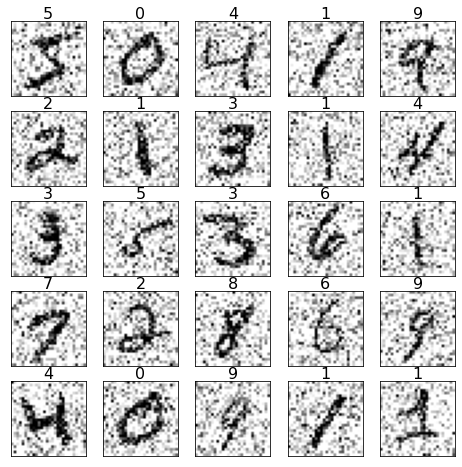

In [7]:
plt.figure(figsize=(8, 8))

for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.title(str(y_train[i]), fontsize=16, color='black', pad=2)
      plt.imshow(train_noisy_images[i].reshape(1, 28, 28)[0], cmap=plt.cm.binary)
      plt.xticks([])
      plt.yticks([])

plt.show()

# Defining our autoencoder model #

In [8]:
model = Sequential()

# encoder network
model.add(Conv2D(filters=128, kernel_size=(2, 2), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same'))

# decoder network
model.add(Conv2D(filters=512, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=(2, 2), strides=(2, 2),
                                          activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(2, 2), activation='relu', padding='same'))


model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2),
                                          activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())

model.add(Conv2D(filters=1, kernel_size=(2, 2), activation='relu', padding='same'))

# to get the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       640       
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       65664     
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       131328    
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 14, 14, 256)       1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       2

## Compile model ##

In [9]:
optimizer = Adam(learning_rate=0.001)
loss = 'mean_squared_error'
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Fitting the model ##

In [ ]:
epochs = 5
batch_size = 256
validation = (val_noisy_images, val_images)
history = model.fit(train_noisy_images, train_images, batch_size=batch_size, epochs=epochs,
                    validation_data=validation)

Epoch 1/5
235/235 [==============================] - 11467s 49s/step - loss: 0.1374 - accuracy: 0.7771 - val_loss: 0.1136 - val_accuracy: 0.8079
Epoch 2/5
 45/235 [====>.........................] - ETA: 2:35:00 - loss: 0.0104 - accuracy: 0.8144

# Model evaluation #
## Loss and accuracy curve ##

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='best')
plt.show()

# Visualizing our predicted images along with real and noised images #

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(10, 19):
    plt.subplot(9, 9, i)
    if i == 14:
        plt.title('Clean Images', fontsize=25, color='Green')
    plt.imshow(test_images[i].reshape(1, 28, 28)[0], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(18, 18))
for i in range(10, 19):
    if i == 15:
        plt.title('Noisy Images', fontsize=25, color='red')
    plt.subplot(9, 9, i)
    plt.imshow(test_noisy_images[i].reshape(1, 28, 28)[0], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(18, 18))
for i in range(10, 19):
    if i == 15:
        plt.title('Denoised Images', fontsize=25, color='Blue')

    plt.subplot(9, 9, i)
    plt.imshow(model.predict(test_noisy_images[i].reshape(1, 28, 28, 1)).reshape(1, 28, 28)[0],
               cmap=plt.cm.binary)

plt.show()